In [4]:
import os
from pathlib import Path

# מתחילים מהמיקום של הנוטבוק/קובץ
cwd = Path().resolve()

# מטפסים למעלה עד שנמצאת תיקיית Data
while not (cwd / "Data").exists() and cwd.parent != cwd:
    cwd = cwd.parent

# שינוי ה-working directory
os.chdir(cwd)
print("📂 Working directory set to:", os.getcwd())


📂 Working directory set to: /Users/talhakimi/Desktop/קורות חיים/Students-rent-price


In [5]:
import pandas as pd
import numpy as np
import re
import ast

# =========================
# פרמטרים
# =========================
RARE_GROUP_THRESH = 50
INPUT_CSV  = 'Data/realestate.csv'
OUTPUT_CSV = 'Data/clean_realestate.csv'
EMB_COL = 'description_embedding'
EMB_DIM = 768  # expected embedding dimension

# =========================
# עזר: דיווח סכימה
# =========================
def schema_report(df, title):
    print(f"\n=== {title} ===")
    print("Shape:", df.shape)
    try:
        print(df.info())
    except Exception:
        pass
    print("Nulls (top 20):\n", df.isnull().sum().sort_values(ascending=False).head(20))

# =========================
# עזר: המרה מספרית גמישה
# =========================
def to_numeric_flex(x):
    if pd.isna(x):
        return np.nan
    s = str(x)
    s = re.sub(r'[^0-9\.\-]', '', s)  # משאיר ספרות/נקודה/מינוס
    if s in ('', '-', '.', '-.', '.-'):
        return np.nan
    try:
        return float(s)
    except Exception:
        return np.nan

# =========================
# עזר: ניקוי קומות
# =========================
def clean_floor(val):
    if pd.isna(val) or val == 'Unknown':
        return np.nan
    s = str(val).strip()
    if 'קרקע' in s or s == '0':
        return 0
    if 'גג' in s or 'roof' in s.lower():
        return -1
    # נסה להמיר מספר
    v = to_numeric_flex(s)
    if pd.isna(v):
        return np.nan
    return np.nan if v > 100 else int(v)

# =========================
# קיבוץ ערים
# =========================
CITY_GROUPS = {
    'גוש דן': ['תל אביב יפו','רמת גן','גבעתיים','בת ים','חולון','בני ברק','קרית אונו','גבעת שמואל'],
    'שפלה': ['ראשון לציון','לוד','רמלה','באר יעקב','אור יהודה','גני תקווה','יהוד מונוסון','אזור','בית דגן'],
    'מזרח מרכז': ['פתח תקווה','ראש העין','אלעד','שוהם','כפר סירקין'],
    'פריפריה קרובה': ['מודיעין מכבים רעות','בית חשמונאי','צפריה','חדיד','טירת יהודה','כפר דניאל','ישרש','כפר הנגיד','גמזו','כפר רות','גינתון']
}
def map_city_to_group(city: str) -> str:
    for g, cities in CITY_GROUPS.items():
        if city in cities:
            return g
    return 'Other'

# =========================
# IQR ללא קריסות (עובד גם עם NaN)
# =========================
def remove_outliers_iqr(df_in, columns, k=1.5):
    df_clean = df_in.copy()
    mask = pd.Series(True, index=df_clean.index)
    for col in [c for c in columns if c in df_clean.columns]:
        s = pd.to_numeric(df_clean[col], errors='coerce')
        valid = s.dropna()
        if valid.empty:
            continue
        Q1 = valid.quantile(0.25)
        Q3 = valid.quantile(0.75)
        IQR = Q3 - Q1
        low, high = (Q1 - k*IQR, Q3 + k*IQR)
        keep = s.between(low, high)
        mask &= keep.fillna(False)  # רשומות בלי ערך — יוצאות
    return df_clean[mask]

# =========================
# 1) קריאה + יישור שמות + parse_dates אם קיים
# =========================
df = pd.read_csv(INPUT_CSV, encoding='utf-8')
df.columns = df.columns.str.strip()
if 'published_at' in df.columns:
    df['published_at'] = pd.to_datetime(df['published_at'], errors='coerce', dayfirst=True)

# =========================
# 2) מיפוי שמות אלטרנטיביים
# =========================
aliases = {
    'adress': 'address', 'Adress': 'address', 'Address': 'address',
    'neighbourhood': 'neighborhood',
    'room_number': 'rooms', 'num_of_rooms': 'rooms',
    'sqm': 'size_sqm', 'area': 'size_sqm',
    'floor_no': 'floor', 'total_floors_no': 'total_floors',
}
for old, new in aliases.items():
    if old in df.columns and new not in df.columns:
        df.rename(columns={old: new}, inplace=True)

schema_report(df, "BEFORE DEDUP & CLEANING")

# =========================
# 3) דה-דופ לפי מפתחות קיימים בלבד
# =========================
unique_keys_all = ["price", "rooms", "size_sqm", "floor", "total_floors", "city", "neighborhood", "address"]
unique_keys = [c for c in unique_keys_all if c in df.columns]
if unique_keys:
    df = df.drop_duplicates(subset=unique_keys)
print(f"Records after unique: {len(df):,}")

# =========================
# 4) ניקוי מחיר
# =========================
if 'price' in df.columns:
    df['price'] = (
        df['price'].astype(str).str.strip()
          .str.replace('[₪,]', '', regex=True)
          .replace({'לא צוין מחיר': pd.NA, 'nan': pd.NA, '': pd.NA})
    )
    df['price'] = pd.to_numeric(df['price'], errors='coerce')

# =========================
# 5) ניקוי city
# =========================
if 'city' in df.columns:
    df['city'] = df['city'].astype(str).str.strip()
    df['city'] = df['city'].replace({'Unknown': np.nan, '': np.nan, 'nan': np.nan})

# =========================
# 6) השלמת קטגוריות חסרות
# =========================
for col in ['apartment_style', 'neighborhood']:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')

# =========================
# 7) המרות מספריות גמישות
# =========================
for c in ['rooms','size_sqm','total_floors']:
    if c in df.columns:
        df[c] = df[c].map(to_numeric_flex)

if 'floor' in df.columns:
    df['floor'] = df['floor'].apply(clean_floor)
    if df['floor'].isna().any():
        median_floor = df['floor'].median()
        df['floor'] = df['floor'].fillna(median_floor)

# =========================
# 8) סינון רשומות חסרות לליבה
# =========================
core_cols = [c for c in ['price','rooms','size_sqm','city'] if c in df.columns]
if core_cols:
    df = df.dropna(subset=core_cols)

# =========================
# 9) price_per_sqm
# =========================
if {'price','size_sqm'}.issubset(df.columns):
    df = df[df['size_sqm'] > 0]
    df['price_per_sqm'] = df['price'] / df['size_sqm']
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = df.dropna(subset=['price_per_sqm'])

# =========================
# 10) מילוי total_floors
# =========================
if 'total_floors' in df.columns and df['total_floors'].isna().any():
    df['total_floors'] = df['total_floors'].fillna(df['total_floors'].median())

# =========================
# 11) קיבוץ ערים
# =========================
if 'city' in df.columns:
    df['city_group'] = df['city'].apply(map_city_to_group)
    counts = df['city_group'].value_counts()
    rare_groups = counts[counts < RARE_GROUP_THRESH].index
    df.loc[df['city_group'].isin(rare_groups), 'city_group'] = 'Other'

schema_report(df, "BEFORE IQR")

# =========================
# 12) IQR
# =========================
columns_to_clean = [c for c in ['price','size_sqm','rooms','price_per_sqm'] if c in df.columns]
df_iqr = remove_outliers_iqr(df, columns_to_clean, k=1.5)

# =========================
# 13) בדיקות לוגיות (ללא חריקות)
# =========================
mask_ratio = pd.Series(True, index=df_iqr.index)
if {'rooms','size_sqm'}.issubset(df_iqr.columns):
    r = pd.to_numeric(df_iqr['rooms'], errors='coerce')
    s = pd.to_numeric(df_iqr['size_sqm'], errors='coerce')
    ratio = r / s
    valid = ratio.dropna()
    if not valid.empty:
        low_r, high_r = valid.quantile([0.01, 0.99])
        mask_ratio = ratio.between(low_r, high_r).fillna(False)

mask_floor = pd.Series(True, index=df_iqr.index)
if {'floor','total_floors'}.issubset(df_iqr.columns):
    f  = pd.to_numeric(df_iqr['floor'], errors='coerce')
    tf = pd.to_numeric(df_iqr['total_floors'], errors='coerce')
    mask_floor = f.isna() | tf.isna() | (f <= tf)

df_final = df_iqr[mask_ratio & mask_floor].copy()

schema_report(df_final, "AFTER ALL FILTERS")
print(f"Final records: {len(df_final):,}")

# =========================
# 13b) Drop rows with NaN or malformed embeddings
# =========================
if EMB_COL in df_final.columns:
    before = len(df_final)
    def is_valid_emb(x):
        try:
            arr = np.array(ast.literal_eval(x), dtype=float) if pd.notna(x) else None
            return arr is not None and arr.shape[0] == EMB_DIM
        except Exception:
            return False
    mask = df_final[EMB_COL].apply(is_valid_emb)
    df_final = df_final[mask]
    after = len(df_final)
    print(f"Dropped {before - after} rows with NaN or malformed embeddings. Remaining: {after:,}")

# =========================
# 14) שמירה
# =========================
df_final.to_csv(OUTPUT_CSV, index=False)
print(f"Saved cleaned data to {OUTPUT_CSV}")

sample = df.sample(300, random_state=42)

# שמירה לקובץ חדש בשם sample_realestate.csv
out_path = Path("Data") / "sample_realestate.csv"
sample.to_csv(out_path, index=False)

print("✅ Sample saved to:", out_path.resolve())

/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_67599/205201171.py:99: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['published_at'] = pd.to_datetime(df['published_at'], errors='coerce', dayfirst=True)



=== BEFORE DEDUP & CLEANING ===
Shape: (28107, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28107 entries, 0 to 28106
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   price                  28107 non-null  object        
 1   address                28107 non-null  object        
 2   description_embedding  28073 non-null  object        
 3   apartment_style        25176 non-null  object        
 4   neighborhood           22838 non-null  object        
 5   city                   24673 non-null  object        
 6   rooms                  28020 non-null  float64       
 7   floor                  25936 non-null  object        
 8   total_floors           25907 non-null  float64       
 9   size_sqm               28103 non-null  float64       
 10  published_at           28107 non-null  datetime64[ns]
 11  type                   28107 non-null  object        
 12  ad_url  

# Exploratory Visualizations
Below are some key visualizations to understand the main patterns in the data.

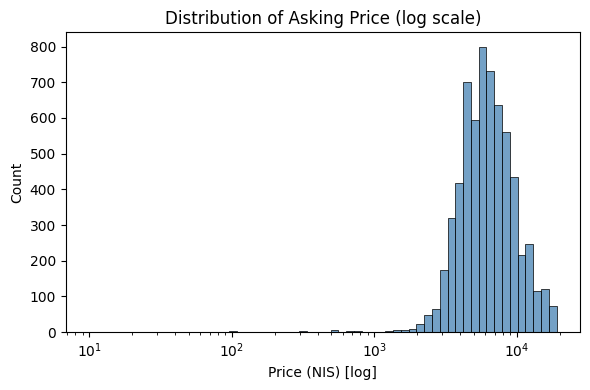

/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_67599/563794442.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_final[df_final['city'].isin(top_cities)],


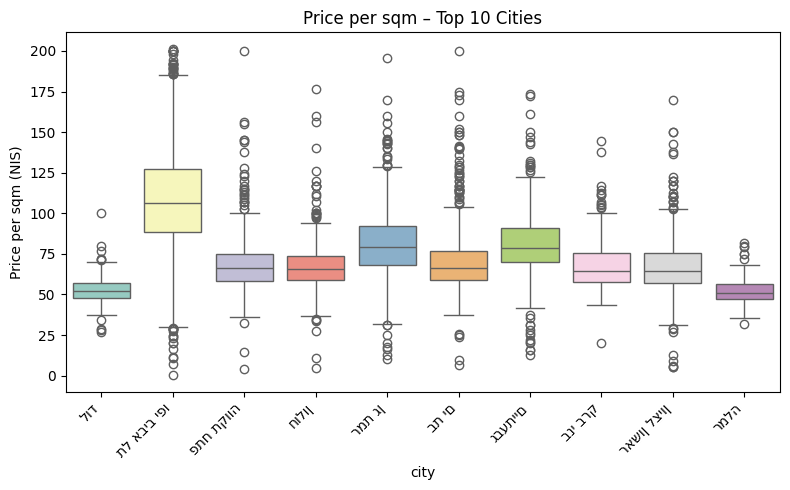

/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_67599/563794442.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_final, x='city_group', y='price_per_sqm', palette='Set3')


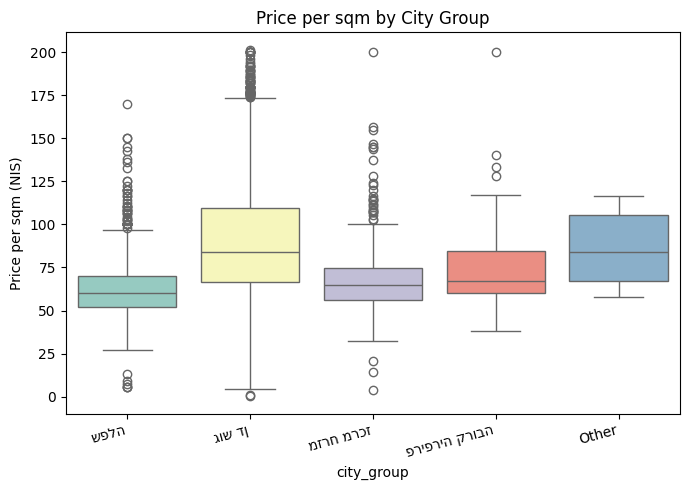

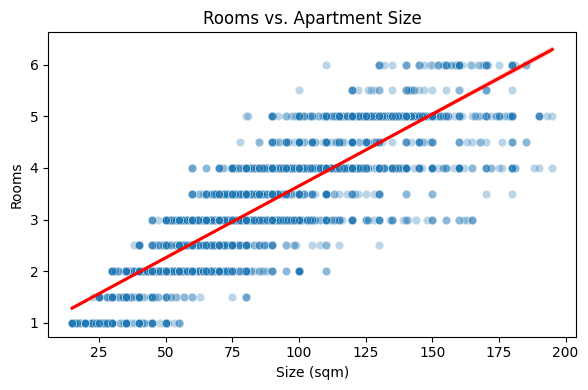


Summary stats:
               price     size_sqm        rooms  price_per_sqm
count   6324.000000  6324.000000  6324.000000    6324.000000
mean    6753.185009    85.165085     3.237113      83.727354
std     3075.014268    33.249500     1.077732      30.736945
min       10.000000    15.000000     1.000000       0.185185
25%     4500.000000    62.000000     2.500000      61.693262
50%     6000.000000    80.000000     3.000000      75.568475
75%     8112.500000   105.000000     4.000000     100.000000
max    19000.000000   195.000000     6.000000     201.388889


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# היסטוגרמת מחיר (log) — steelblue
if 'price' in df_final.columns and not df_final.empty:
    plt.figure(figsize=(6,4))
    plt.title('Distribution of Asking Price (log scale)')
    sns.histplot(df_final['price'], bins=60, log_scale=True, color='steelblue')
    plt.xlabel('Price (NIS) [log]')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# Boxplot לפי 10 הערים הגדולות — Set3
if {'city','price_per_sqm'}.issubset(df_final.columns) and not df_final.empty:
    plt.figure(figsize=(8,5))
    top_cities = df_final['city'].value_counts().nlargest(10).index
    sns.boxplot(data=df_final[df_final['city'].isin(top_cities)],
                x='city', y='price_per_sqm', palette='Set3')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Price per sqm (NIS)')
    plt.title('Price per sqm – Top 10 Cities')
    plt.tight_layout()
    plt.show()

# Boxplot לפי קבוצות עיר — ברירת מחדל
if {'city_group','price_per_sqm'}.issubset(df_final.columns) and not df_final.empty:
    plt.figure(figsize=(7,5))
    sns.boxplot(data=df_final, x='city_group', y='price_per_sqm', palette='Set3')
    plt.xticks(rotation=15, ha='right')
    plt.ylabel('Price per sqm (NIS)')
    plt.title('Price per sqm by City Group')
    plt.tight_layout()
    plt.show()

# פיזור Rooms מול Size + קו רגרסיה אדום
if {'size_sqm','rooms'}.issubset(df_final.columns) and not df_final.empty:
    plt.figure(figsize=(6,4))
    sample_n = min(5000, len(df_final))
    sns.scatterplot(data=df_final.sample(sample_n, random_state=1),
                    x='size_sqm', y='rooms', alpha=0.3)
    sns.regplot(data=df_final, x='size_sqm', y='rooms', scatter=False, color='red')
    plt.xlabel('Size (sqm)')
    plt.ylabel('Rooms')
    plt.title('Rooms vs. Apartment Size')
    plt.tight_layout()
    plt.show()

# סטטיסטיקות
stats_cols = [c for c in ['price', 'size_sqm', 'rooms', 'price_per_sqm'] if c in df_final.columns]
if stats_cols and not df_final.empty:
    summary_stats = df_final[stats_cols].describe()
    print("\nSummary stats:\n", summary_stats)

# Key insights
Overall price distribution
• The log-scaled histogram shows a clear concentration of listings between roughly ₪5 K – ₪10 K per square meter, with very few extreme values after outlier removal.
• The right-tail is short, confirming that the IQR filter successfully trimmed unrealistic luxury-price records.

Regional price differences
• Box-plots for the 10 most common cities reveal strong geographic disparity.
– Median price-per-sqm varies by more than 2× between the cheapest and most expensive cities.
– Some cities exhibit long upper whiskers, indicating small clusters of premium properties; others are comparatively homogeneous.
• This suggests that location will be a dominant predictor in any pricing model.

Size versus layout efficiency
• The scatterplot (5 000-sample) and red trend line demonstrate an almost linear relationship of ~1 room per ≈ 25 sqm.
• Points lying well above the line mark “compact” apartments (many rooms for their size), potentially appealing to investors seeking high rent per sqm.
• Outliers below the line highlight unusually spacious apartments that might command a premium for open layouts.

Descriptive statistics snapshot
• Typical apartment: 84 sqm, 3 rooms, asking price ≈ ₪6.4 K per sqm.
• The interquartile range (IQR) for size (67-108 sqm) and rooms (3-4) confirms that most listings are mid-sized family units
• Maximums (~195 sqm, 5.5 rooms) hint at small representation of luxury penthouses; minimums (25 sqm, 1.5 rooms) reflect studio/one-bed listings.

Data quality confirmation
• No missing values in the core numerical fields; logical consistency checks (floor vs. total_floors, room-to-size ratio) passed.
• The sample of 19 464 records is therefore clean and ready for deeper modeling or segmentation.